## First, let's test P_binary.py

In [1]:
import matplotlib.pyplot as plt
import sys
sys.path.append('../src')
import P_binary
import P_random
import const as c
import numpy as np
from numpy.random import normal
import corner
from astropy.table import Table

%matplotlib inline

In [2]:
P_binary.generate_binary_set()

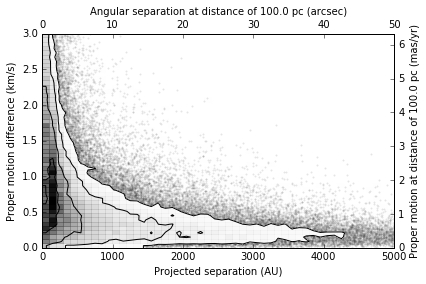

In [3]:
P_binary.create_plot_binary(dist=100.0, num_sys=100000, bins=50)

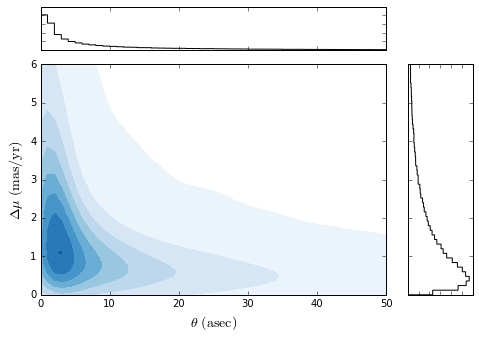

In [12]:

fig = plt.figure()

ax1 = fig.add_axes([0.0, 0.0, 0.8, 0.8])
ax2 = fig.add_axes([0.0, 0.85, 0.8, 0.15])
ax3 = fig.add_axes([0.85, 0.0, 0.15, 0.8])


nbins = 50
xmin, xmax = 0.0, 50.0
ymin, ymax = 0.0, 6.0


# Main plot
theta_test = np.linspace(xmin, xmax, nbins)
delta_mu_test = np.linspace(ymin, ymax, nbins)
X, Y = np.meshgrid(theta_test, delta_mu_test)

Z = P_binary.get_P_binary(X.flatten(), Y.flatten())

levels = np.linspace(0.0001, 0.03, 10)
ax1.tricontourf(X.flatten(), Y.flatten(), Z, cmap='Blues', levels=levels, extend='max')

ax1.set_xlabel(r"$\theta\ ({\rm asec})$", fontsize=14)
ax1.set_ylabel(r"$\Delta \mu\ ({\rm mas/yr})$", fontsize=14)


# Theta histogram
ax2.hist(P_binary.binary_set["theta"], histtype='step', bins=nbins, color='k', 
         range=[xmin,xmax], normed=True)
ax2.set_xticklabels([])
ax2.set_yticklabels([])


# Delta mu histogram
ax3.hist(P_binary.binary_set["delta_mu"], histtype='step', bins=nbins, color='k', 
         range=[ymin,ymax], orientation=u'horizontal', normed=True)
ax3.set_xticklabels([])
ax3.set_yticklabels([])

plt.show()


## Now, let's load up the rNLTT catalog

In [3]:
# Read in sample from Tycho-2 table

filename = ('../data/rNLTT/catalog_tabs.dat')
t = Table.read(filename, format='ascii', guess=True)


# Change proper motion units from asec/yr to mas/yr
t['mu_ra'] = 1.0e3*t['mu_ra']
t['mu_dec'] = 1.0e3*t['mu_dec']
t['mu_ra_err'] = 1.0e3*t['mu_ra_err']
t['mu_dec_err'] = 1.0e3*t['mu_dec_err']


# Set minimum proper motion uncertainties to 1 mas/yr
min_t = np.ones(len(t))
tmp_t_ra = np.max((min_t, t['mu_ra_err']), axis=0)
tmp_t_dec = np.max((min_t, t['mu_dec_err']), axis=0)
t['mu_ra_err'] = tmp_t_ra
t['mu_dec_err'] = tmp_t_dec

### Estimates for number of nearby stars

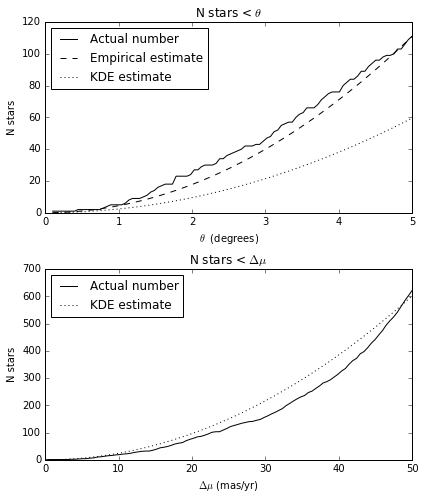

In [8]:
fig, ax = plt.subplots(2,1, figsize=(6,7))

i=0


# Position panel
ra_in = t['ra'][i]
dec_in = t['dec'][i] 
#print ra_in, dec_in

radius = np.linspace(0.1, 5.0, 100)
nstars = np.zeros(100)
for j in np.arange(100):
    r = radius[j]
    nstars[j] = P_random.nstars_nearby(ra_in, dec_in, radius=r, catalog=t)-1
ax[0].plot(radius, nstars, color='k', label='Actual number')

# Compare to density estimate derived from a 5 degree radius
r = 5.0
n_stars_near = P_random.nstars_nearby(ra_in, dec_in, radius=r, catalog=t)-1
n_density = n_stars_near / (4.0*np.pi*r**2)
y = (4.0*np.pi)*n_density*radius**2
ax[0].plot(radius,y, color='k', linestyle='--', label='Empirical estimate')

pos_density = P_random.get_sigma_pos(ra_in, dec_in, catalog=t, method='kde')
norm_factor = P_random.pos_kde.factor*len(t['ra'])
P_pos = 4.0*np.pi*radius**2*pos_density
ax[0].plot(radius, P_pos*norm_factor, color='k', linestyle='dotted', label='KDE estimate')


ax[0].set_title(r'N stars < $\theta$')
ax[0].set_xlabel(r'$\theta\ $ (degrees)')
ax[0].set_ylabel('N stars')
ax[0].legend(loc=2)




# Proper motion panel
mu_ra_in = t['mu_ra'][i]
mu_dec_in = t['mu_dec'][i] 

pm_density = P_random.get_sigma_mu(mu_ra_in, mu_dec_in, catalog=t, method='kde')
delta_mu = np.linspace(0.0, 50.0, 100)
P_mu = 4.0*np.pi*delta_mu**2*pm_density

N_stars = np.zeros(100)
for i in np.arange(100):
    N_stars[i] = P_random.nstars_nearby_mu(mu_ra_in, mu_dec_in, delta_mu[i], catalog=t)

ax[1].plot(delta_mu, N_stars, color='k', label='Actual number')


norm_factor = P_random.mu_kde.factor*len(t['ra'])
ax[1].plot(delta_mu, P_mu*norm_factor, color='k', linestyle='dotted', label='KDE estimate')

ax[1].set_xlim(0.0,50.0)

ax[1].set_title(r'N stars < $\Delta \mu$')
ax[1].set_xlabel(r'$\Delta \mu$ (mas/yr)')
ax[1].set_ylabel('N stars')

ax[1].legend(loc=2)


plt.tight_layout()
plt.show()

### Check the convergence of empirical vs. kde density estimations

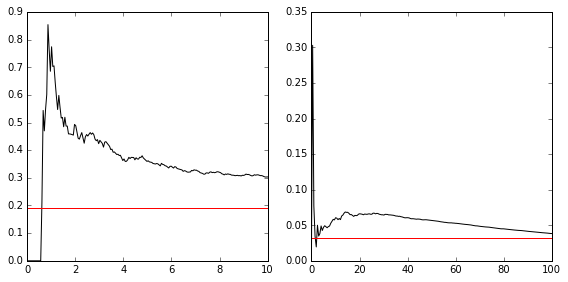

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(8,4))

num=200
j=5


# position
rad = np.linspace(0.01, 10.0, num)
sigma_pos = np.zeros(num)
for i in np.arange(num):
    sigma_pos[i] = P_random.get_sigma_pos(t['ra'][j], t['dec'][j], catalog=t, 
                                        rad=rad[i], method='empirical')

sigma_pos_kde = P_random.get_sigma_pos(t['ra'][j], t['dec'][j], catalog=t, method='kde')

# Adjust for mu_kde "bin" size
sigma_pos_kde = sigma_pos_kde * P_random.pos_kde.factor*len(t['ra'])
    
ax[0].plot(rad, sigma_pos, color='k')
ax[0].axhline(sigma_pos_kde, color='r')


# Proper motion
rad = np.linspace(0.01, 100.0, num)
sigma_mu = np.zeros(num)
for i in np.arange(num):
    sigma_mu[i] = P_random.get_sigma_mu(t['mu_ra'][j], t['mu_dec'][j], catalog=t, 
                                        rad=rad[i], method='empirical')

sigma_mu_kde = P_random.get_sigma_mu(t['mu_ra'][j], t['mu_dec'][j], catalog=t, method='kde')

# Adjust for mu_kde "bin" size
sigma_mu_kde = sigma_mu_kde * P_random.mu_kde.factor*len(t['ra'])
    
ax[1].plot(rad, sigma_mu, color='k')
ax[1].axhline(sigma_mu_kde, color='r')


plt.tight_layout()
plt.show()

In [5]:
#length = len(t)
length = 60
print "We are testing", length, "stars..."

dtype = [('i_1','i4'),('i_2','i4'),('NLTT_1','i4'),('NLTT_2','i4'),('P_random','f8'),('P_binary','f8')]
prob_out = np.zeros(length, dtype=dtype)

for i in np.arange(length):
    
    if i%100 == 0: print i
    
    star1 = t['ra'][i], t['dec'][i], t['mu_ra'][i], t['mu_dec'][i], t['mu_ra_err'][i], t['mu_dec_err'][i]

    # Random Alignment
    pos_density = P_random.get_sigma_pos(star1[0], star1[1], catalog=t, method='kde')
    pm_density = P_random.get_sigma_mu(star1[2], star1[3], catalog=t, method='kde')

    
    prob = np.zeros(len(t)-i-1)
    for j in np.arange(len(t)-i-1)+i+1:

        if t['NLTT'][i] == t['NLTT'][j]:
            prob[j-i-1] = 1000.0
            continue
            
        star2 = t['ra'][j], t['dec'][j], t['mu_ra'][j], t['mu_dec'][j], t['mu_ra_err'][j], t['mu_dec_err'][j]
        
        delta_pm_ra_err = np.sqrt(star1[4]**2 + star2[4]**2)
        delta_pm_dec_err = np.sqrt(star1[5]**2 + star2[5]**2)
        #delta_pm_loc = np.sqrt((star1[2]-star2[2])**2 + (star1[3]-star2[3])**2)
        #delta_pm_err = np.sqrt(star1[4]**2 + star1[5]**2 + star2[4]**2 + star2[5]**2)
        #delta_pm = normal(loc=delta_pm_loc, scale=delta_pm_err, size=100)
        
        
        
        prob[j-i-1], P_pos, P_mu = P_random.get_P_random_alignment(star1[0], star1[1], star2[0], star2[1],
                                          star1[2], star1[3], star2[2], star2[3], 
                                          delta_mu_ra_err=delta_pm_ra_err, delta_mu_dec_err=delta_pm_dec_err,
                                          pos_density=pos_density, pm_density=pm_density,
                                          catalog=t)
        
    # Binary probability for best matching pair
    j = np.argmin(prob)+i+1
    star2 = t['ra'][j], t['dec'][j], t['mu_ra'][j], t['mu_dec'][j], t['mu_ra_err'][j], t['mu_dec_err'][j]    
    theta = P_random.get_theta_proj_degree(star1[0], star1[1], star2[0], star2[1]) * 3600.0
    delta_mu = np.sqrt((star1[2]-star2[2])**2 + (star1[3]-star2[3])**2)
    delta_mu_err = np.sqrt(star1[4]**2 + star1[5]**2 + star2[4]**2 + star2[5]**2)

    # Only include binary probability if star is within 1 degree
    if theta > 3600.0:
        prob_binary = 0.0
    else:
        delta_mu_sample = normal(loc=delta_mu, scale=delta_mu_err, size=100)
        prob_binary = 1.0/100 * np.sum(P_binary.get_P_binary(theta, delta_mu_sample))

    prob_out['i_1'][i] = i
    prob_out['i_2'][i] = j
    prob_out['NLTT_1'][i] = t['NLTT'][i]
    prob_out['NLTT_2'][i] = t['NLTT'][j]
    prob_out['P_random'][i] = prob[j-i-1]
    prob_out['P_binary'][i] = prob_binary
    print i, t['NLTT'][i], t['NLTT'][j], prob[j-i-1], prob_binary, \
            t['mu_ra'][i], t['mu_dec'][i], t['mu_ra'][j], t['mu_dec'][j]
    # print i, np.argmin(prob)+i+1, prob[np.argmin(prob)]
    
print "... finished"

We are testing 60 stars...
0
0 2 3 4.91135322552e-07 0.0 -79.7000006 -110.9 -67.1999976 -184.699997
1 3 297 2.83525782071e-05 0.0 -67.1999976 -184.699997 -42.7000001 -198.899999
2 4 58808 1.36480271192e-06 0.0 281.800002 -47.2000018 224.399999 -76.3000026
3 5 58772 9.79580350201e-07 0.0 -394.400001 -422.800004 -140.000001 -156.000003
4 6 105 5.29489133828e-06 0.0 205.1 -35.3000015 194.399998 -24.7000009
5 7 58713 1.25216438093e-05 0.0 211.199999 -34.8000005 164.399996 -75.3000006
6 8 58742 6.17817489527e-07 0.0 144.600004 -744.099975 351.500005 -109.999999
7 9 87 8.10777360943e-07 0.0 388.999999 -26.9000009 295.19999 3.50000011
8 10 53 5.90194557758e-07 0.0 417.800009 -59.2 255.499989 -71.6999993
9 11 125 6.17852937539e-06 0.0 181.700006 -67.1999976 172.600001 -88.5000005
10 13 50 1.15395418105e-06 0.0 106.1 -185.200006 108.7 -196.099997
11 17 45 3.02931681727e-06 0.0 200.900003 -39.0999988 172.700003 43.0999994
12 18 275 2.03375890353e-06 0.0 326.900005 -97.1999988 341.699988 -131.200

In [8]:
print prob_out
#i, j = 35, 36
#print t['ra'][i], t['dec'][i], t['ra'][j], t['dec'][j]
#print t['mu_ra'][i], t['mu_dec'][i], t['mu_ra'][j], t['mu_dec'][j], \
#        t['mu_ra_err'][i], t['mu_dec_err'][i], t['mu_ra_err'][j], t['mu_dec_err'][j]

[(0, 1, 2, 3, 4.911353225515255e-07, 0.0)
 (1, 192, 3, 297, 2.835257820712676e-05, 0.0)
 (2, 36061, 4, 58808, 1.3648027119203646e-06, 0.0)
 (3, 36043, 5, 58772, 9.795803502012775e-07, 0.0)
 (4, 68, 6, 105, 5.294891338280345e-06, 0.0)
 (5, 36015, 7, 58713, 1.2521643809282345e-05, 0.0)
 (6, 36026, 8, 58742, 6.178174895265535e-07, 0.0)
 (7, 54, 9, 87, 8.107773609427511e-07, 0.0)
 (8, 35, 10, 53, 5.901945577580586e-07, 0.0)
 (9, 80, 11, 125, 6.1785293753930146e-06, 0.0)
 (10, 32, 13, 50, 1.153954181048736e-06, 0.0)
 (11, 29, 17, 45, 3.0293168172748375e-06, 0.0)
 (12, 177, 18, 275, 2.0337589035306374e-06, 0.0)
 (13, 66, 20, 103, 8.818204733221667e-06, 0.0)
 (14, 22, 21, 35, 3.617798261151536e-05, 0.0)
 (15, 98, 22, 155, 2.085830686071507e-06, 0.0)
 (16, 201, 24, 316, 2.2272504116048146e-06, 0.0)
 (17, 36068, 25, 58817, 1.6031998643712398e-06, 0.0)
 (18, 1813, 29, 2752, 3.7398887239704086e-06, 0.0)
 (19, 39, 30, 60, 8.861729697660318e-07, 0.0)
 (20, 174, 32, 271, 1.6735297401981302e-05, 0.0)

### Compare with Chaname & Gould catalog

In [23]:
# Read in pairs table

filename_CG = ('../data/rNLTT/Chaname_Gould_pairs.dat')
CG_pairs = Table.read(filename_CG, format='cds')
print CG_pairs.colnames

['NLTT-A', 'NLTT-B', 'RAdegA', 'DEdegA', 'RAdegB', 'DEdegB', 'pmRA-A', 'pmDE-A', 'pmRA-B', 'pmDE-B', 'VmagA', '(V-J)A', 'VmagB', '(V-J)B', 'SC-A', 'SC-B', 'CCode', 'Delpm', 'DelSep', 'PosAng', 'Bin', 'Allen']


In [40]:

for i in np.arange(5):
    print CG_pairs['NLTT-A'][i], CG_pairs['NLTT-B'][i], CG_pairs['CCode'][i]

2 3 6
30 60 3
53 54 1
84 86 1
158 159 1
